# Modelo XGBoost para Predicción de Potencia en Granjas Undimotrices

Este notebook implementa el modelo completo:
- Preprocesamiento de datos
- Ordenamiento canónico (solución a invarianza de permutación)
- Ingeniería de características
- Entrenamiento de XGBoost
- Evaluación y métricas


In [1]:
# Importaciones
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import pickle
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

# Optimización Bayesiana con Optuna
try:
    import optuna
    OPTUNA_AVAILABLE = True
except ImportError:
    print("Optuna no está instalado. Instala con: pip install optuna")
    OPTUNA_AVAILABLE = False
    # Fallback a RandomizedSearchCV si Optuna no está disponible
    from sklearn.model_selection import RandomizedSearchCV

warnings.filterwarnings('ignore')

# Configuración
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Directorios
DATASET_DIR = Path("dataset")
MODELS_DIR = Path("models")
MODELS_DIR.mkdir(exist_ok=True)

print("Librerías importadas correctamente")


Librerías importadas correctamente


C:\Users\Usuario\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Clase de Ingeniería de Características


In [2]:
class FeatureEngineer:
    """Clase para ingeniería de características con ordenamiento canónico."""

    def __init__(self, n_converters):
        self.n_converters = n_converters

    def canonical_ordering(self, coordinates):
        """
        Ordenamiento canónico: ordenar por X (ascendente), luego Y (ascendente).
        Resuelve el problema de invarianza de permutación.

        Args:
            coordinates: array de shape (n_samples, n_converters, 2) con [X, Y]

        Returns:
            coordinates_ordered: coordenadas ordenadas canónicamente
        """
        n_samples = coordinates.shape[0]
        coordinates_ordered = np.zeros_like(coordinates)

        for i in range(n_samples):
            coords = coordinates[i].copy()
            # Ordenar lexicográficamente: primero por X, luego por Y
            sort_indices = np.lexsort((coords[:, 1], coords[:, 0]))
            coordinates_ordered[i] = coords[sort_indices]

        return coordinates_ordered

    def extract_coordinates(self, df):
        """Extrae coordenadas X, Y del dataframe."""
        x_cols = [f'X{i+1}' for i in range(self.n_converters)]
        y_cols = [f'Y{i+1}' for i in range(self.n_converters)]

        x_values = df[x_cols].values
        y_values = df[y_cols].values

        # Reshape a (n_samples, n_converters, 2)
        coordinates = np.stack([x_values, y_values], axis=2)
        return coordinates

    def compute_centroid(self, coordinates):
        """Calcula el centroide de cada configuración."""
        return coordinates.mean(axis=1)

    def compute_distances_to_centroid(self, coordinates, centroids):
        """Calcula distancia de cada WEC al centroide."""
        n_samples = coordinates.shape[0]
        distances = np.zeros((n_samples, self.n_converters))

        for i in range(n_samples):
            centroid = centroids[i]
            coords = coordinates[i]
            distances[i] = np.sqrt(np.sum((coords - centroid)**2, axis=1))

        return distances

    def compute_neighbor_distances(self, coordinates, k=3):
        """Calcula distancia a los k vecinos más cercanos."""
        n_samples = coordinates.shape[0]
        min_distances = np.zeros((n_samples, self.n_converters))
        mean_distances = np.zeros((n_samples, self.n_converters))

        for i in range(n_samples):
            coords = coordinates[i]

            for j in range(self.n_converters):
                distances = np.sqrt(np.sum((coords - coords[j])**2, axis=1))
                distances[j] = np.inf  # Excluir distancia a sí mismo

                k_nearest = np.partition(distances, min(k, len(distances)-1))[:k+1]
                k_nearest = k_nearest[k_nearest != np.inf]

                if len(k_nearest) > 0:
                    min_distances[i, j] = np.min(k_nearest)
                    mean_distances[i, j] = np.mean(k_nearest[:k])

        return min_distances, mean_distances

    def compute_spatial_metrics(self, coordinates):
        """Calcula métricas de dispersión espacial."""
        n_samples = coordinates.shape[0]
        metrics = {
            'max_distance': np.zeros(n_samples),
            'min_distance': np.zeros(n_samples),
            'mean_distance': np.zeros(n_samples),
            'std_distance': np.zeros(n_samples)
        }

        for i in range(n_samples):
            coords = coordinates[i]
            distances = []
            for j in range(self.n_converters):
                for k in range(j+1, self.n_converters):
                    dist = np.linalg.norm(coords[j] - coords[k])
                    distances.append(dist)

            if distances:
                distances = np.array(distances)
                metrics['max_distance'][i] = np.max(distances)
                metrics['min_distance'][i] = np.min(distances)
                metrics['mean_distance'][i] = np.mean(distances)
                metrics['std_distance'][i] = np.std(distances)

        return metrics

    def compute_shadowing_index(self, coordinates, wave_direction='left', y_bandwidth=50.0):
        """
        Calcula el índice de sombra (shadowing) basado en la dirección de las olas.
        
        Si las olas vienen de la izquierda (X negativo), cuenta cuántos WECs están
        "aguas arriba" (con X menor) de cada WEC, dentro de un ancho de banda en Y.
        
        Args:
            coordinates: array (n_samples, n_converters, 2) con coordenadas ordenadas
            wave_direction: 'left' (olas desde X negativo) o 'right' (olas desde X positivo)
            y_bandwidth: ancho de banda en Y para considerar vecinos "en frente"
        
        Returns:
            shadowing_index: array (n_samples, n_converters) con conteo de WECs aguas arriba
        """
        n_samples = coordinates.shape[0]
        shadowing_index = np.zeros((n_samples, self.n_converters))
        
        for i in range(n_samples):
            coords = coordinates[i]  # (n_converters, 2)
            
            for j in range(self.n_converters):
                current_x = coords[j, 0]
                current_y = coords[j, 1]
                
                # Contar WECs "aguas arriba" según dirección de olas
                upstream_count = 0
                for k in range(self.n_converters):
                    if k == j:
                        continue
                    
                    other_x = coords[k, 0]
                    other_y = coords[k, 1]
                    
                    # Verificar si está dentro del ancho de banda en Y
                    y_distance = abs(other_y - current_y)
                    if y_distance > y_bandwidth:
                        continue
                    
                    # Verificar si está aguas arriba según dirección
                    if wave_direction == 'left':
                        # Olas desde izquierda: aguas arriba = X menor
                        if other_x < current_x:
                            upstream_count += 1
                    elif wave_direction == 'right':
                        # Olas desde derecha: aguas arriba = X mayor
                        if other_x > current_x:
                            upstream_count += 1
                
                shadowing_index[i, j] = upstream_count
        
        return shadowing_index

    def transform(self, df):
        """
        Transforma el dataframe aplicando todas las transformaciones.

        Returns:
            X: array de features (n_samples, n_features)
            y: array de target (n_samples,)
            feature_names: lista de nombres de features
        """
        # Extraer coordenadas
        coordinates = self.extract_coordinates(df)

        # Aplicar ordenamiento canónico (CRÍTICO)
        coordinates = self.canonical_ordering(coordinates)

        # Aplanar coordenadas ordenadas
        n_samples = coordinates.shape[0]
        X_coords = coordinates.reshape(n_samples, -1)

        # Nombres de features de coordenadas
        coord_feature_names = []
        for i in range(self.n_converters):
            coord_feature_names.append(f'X{i+1}_ordered')
            coord_feature_names.append(f'Y{i+1}_ordered')

        X_list = [X_coords]
        feature_names_list = [coord_feature_names]

        # Features de ingeniería
        centroids = self.compute_centroid(coordinates)
        dist_to_centroid = self.compute_distances_to_centroid(coordinates, centroids)
        min_dist, mean_dist = self.compute_neighbor_distances(coordinates, k=3)
        spatial_metrics = self.compute_spatial_metrics(coordinates)
        
        # Shadowing Index (efecto sombra basado en dirección de olas)
        # Asumimos olas desde la izquierda (X negativo) por defecto
        shadowing_index = self.compute_shadowing_index(coordinates, wave_direction='left', y_bandwidth=50.0)

        X_list.extend([
            dist_to_centroid,
            min_dist,
            mean_dist,
            np.column_stack([
                spatial_metrics['max_distance'],
                spatial_metrics['min_distance'],
                spatial_metrics['mean_distance'],
                spatial_metrics['std_distance']
            ]),
            shadowing_index  # Agregar shadowing index
        ])

        feature_names_list.extend([
            [f'dist_centroid_{i+1}' for i in range(self.n_converters)],
            [f'min_dist_neighbor_{i+1}' for i in range(self.n_converters)],
            [f'mean_dist_neighbor_{i+1}' for i in range(self.n_converters)],
            ['max_distance', 'min_distance', 'mean_distance', 'std_distance'],
            [f'shadowing_index_{i+1}' for i in range(self.n_converters)]  # Shadowing index por WEC
        ])

        # Concatenar todas las features
        X = np.hstack(X_list)
        feature_names = [name for sublist in feature_names_list for name in sublist]

        # Extraer target
        y = df['Total_Power'].values

        return X, y, feature_names

print("Clase FeatureEngineer definida")



Clase FeatureEngineer definida


## 2. Carga y Preprocesamiento de Datos


In [3]:
# Configuración del dataset a procesar
DATASET_NAME = "perth_100"# Cambiar a "sydney_49", "perth_100", "sydney_100"según necesidad

# Mapeo de nombres a archivos
dataset_files = {
 "perth_49": "WEC_Perth_49.csv",
 "perth_100": "WEC_Perth_100.csv",
 "sydney_49": "WEC_Sydney_49.csv",
 "sydney_100": "WEC_Sydney_100.csv"
}
DATASET_FILE = DATASET_DIR / dataset_files[DATASET_NAME]

# Determinar número de convertidores
if "49"in DATASET_NAME:
 N_CONVERTERS = 49
else:
 N_CONVERTERS = 100

print(f"Dataset: {DATASET_NAME}")
print(f"Archivo: {DATASET_FILE}")
print(f"Convertidores: {N_CONVERTERS}")

# Cargar datos
df = pd.read_csv(DATASET_FILE)
print(f"Datos cargados: {len(df):,} filas × {len(df.columns)} columnas")

# Eliminar duplicados
df_original = len(df)
df = df.drop_duplicates()
print(f"Duplicados eliminados: {df_original - len(df):,} filas")
print(f"Filas únicas: {len(df):,}")


Dataset: perth_100
Archivo: dataset\WEC_Perth_100.csv
Convertidores: 100
Datos cargados: 7,277 filas × 302 columnas
Duplicados eliminados: 4,540 filas
Filas únicas: 2,737


In [4]:
# Aplicar ingeniería de características
fe = FeatureEngineer(N_CONVERTERS)
X, y, feature_names = fe.transform(df)

print(f"Ingeniería de características completada")
print(f"Features generadas: {len(feature_names)}")
print(f"Shape: X={X.shape}, y={y.shape}")
print(f"Primeras 10 features: {feature_names[:10]}")
print(f"Últimas 5 features: {feature_names[-5:]}")

# Estadísticas
print(f"Estadísticas de X:")
print(f"Min: {X.min():.2f}, Max: {X.max():.2f}")
print(f"Mean: {X.mean():.2f}, Std: {X.std():.2f}")
print(f"Estadísticas de y (Total_Power):")
print(f"Min: {y.min():.2f}, Max: {y.max():.2f}")
print(f"Mean: {y.mean():.2f}, Std: {y.std():.2f}")


Ingeniería de características completada
Features generadas: 604
Shape: X=(2737, 604), y=(2737,)
Primeras 10 features: ['X1_ordered', 'Y1_ordered', 'X2_ordered', 'Y2_ordered', 'X3_ordered', 'Y3_ordered', 'X4_ordered', 'Y4_ordered', 'X5_ordered', 'Y5_ordered']
Últimas 5 features: ['shadowing_index_96', 'shadowing_index_97', 'shadowing_index_98', 'shadowing_index_99', 'shadowing_index_100']
Estadísticas de X:
Min: 0.00, Max: 2050.61
Mean: 356.13, Std: 394.66
Estadísticas de y (Total_Power):
Min: 6099480.37, Max: 7364527.68
Mean: 6959156.87, Std: 199840.15


## 3. División Train/Validation/Test


## Opciones de Entrenamiento

A continuación hay dos opciones:

**Opción A (Sección 4-5)**: Entrenar un modelo para el dataset configurado en `DATASET_NAME`
- Útil para exploración, pruebas y desarrollo
- Permite ver resultados detallados de un dataset

**Opción B (Sección 6)**: Entrenar modelos para TODOS los datasets en paralelo
- Útil para producción y entrenamiento completo
- Más eficiente, entrena todos los modelos a la vez
- Usa hiperparámetros optimizados para reducir overfitting

**Recomendación**: Si quieres entrenar todos los modelos, ve directamente a la Sección 6.

In [5]:
# División train/val/test para entrenamiento individual (70% train / 15% val / 15% test)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.15/0.85, random_state=42  # 15% del total
)

# Normalización
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"División de datos:")
print(f"  Train: {len(X_train):,} muestras")
print(f"  Validation: {len(X_val):,} muestras")
print(f"  Test: {len(X_test):,} muestras")
print(f"\nDatos normalizados")


División de datos:
  Train: 1,915 muestras
  Validation: 411 muestras
  Test: 411 muestras

Datos normalizados


## 6. Entrenamiento Paralelo para Todos los Datasets

Esta sección entrena modelos para todos los datasets en paralelo con hiperparámetros optimizados para reducir overfitting.

In [6]:
from joblib import Parallel, delayed
import time
from pathlib import Path
from sklearn.model_selection import cross_val_score

def optimize_xgboost_with_optuna(X_train, y_train, X_val, y_val, n_trials=50, timeout=None):
    """
    Optimiza hiperparámetros de XGBoost usando Optuna (optimización bayesiana).
    
    Args:
        X_train: datos de entrenamiento
        y_train: target de entrenamiento
        X_val: datos de validación
        y_val: target de validación
        n_trials: número de trials de Optuna
        timeout: tiempo máximo en segundos (None = sin límite)
    
    Returns:
        best_model: mejor modelo XGBoost encontrado
        best_params: mejores hiperparámetros
    """
    if not OPTUNA_AVAILABLE:
        # Fallback a RandomizedSearchCV si Optuna no está disponible
        from sklearn.model_selection import RandomizedSearchCV
        param_grid = {
            'n_estimators': [100, 200],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.05, 0.1],
            'subsample': [0.7, 0.8],
            'reg_alpha': [0.1, 1.0, 10.0],
            'reg_lambda': [1.0, 10.0, 100.0],
            'min_child_weight': [3, 5]
        }
        print("Usando RandomizedSearchCV (fallback, Optuna no disponible)")
        xgb_model = RandomizedSearchCV(
            xgb.XGBRegressor(random_state=42, n_jobs=-1),
            param_grid,
            n_iter=50,
            cv=3,
            scoring='neg_mean_squared_error',
            n_jobs=-1,
            verbose=0,
            random_state=42
        )
        xgb_model.fit(X_train, y_train)
        return xgb_model.best_estimator_, xgb_model.best_params_
    
    def objective(trial):
        """Función objetivo para Optuna."""
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 100.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 100.0, log=True),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'random_state': 42,
            'n_jobs': -1
        }
        
        model = xgb.XGBRegressor(**params)
        model.fit(X_train, y_train)
        
        # Evaluar en validación
        y_pred = model.predict(X_val)
        mse = mean_squared_error(y_val, y_pred)
        
        return mse
    
    print(f"Optimizando con Optuna ({n_trials} trials)...")
    study = optuna.create_study(direction='minimize', study_name='xgboost_optimization')
    study.optimize(objective, n_trials=n_trials, timeout=timeout, show_progress_bar=True)
    
    # Entrenar modelo final con mejores parámetros
    best_params = study.best_params
    best_params['random_state'] = 42
    best_params['n_jobs'] = -1
    
    print(f"Mejores parámetros encontrados:")
    for key, value in best_params.items():
        if key not in ['random_state', 'n_jobs']:
            print(f"  {key}: {value}")
    print(f"  Mejor MSE: {study.best_value:.2f}")
    
    best_model = xgb.XGBRegressor(**best_params)
    best_model.fit(X_train, y_train)
    
    return best_model, best_params

def train_model_for_dataset(dataset_name):
    """
    Entrena un modelo XGBoost para un dataset específico.
    
    Args:
        dataset_name: nombre del dataset ('perth_49', 'sydney_49', 'perth_100', 'sydney_100')
    
    Returns:
        dict: resultados del entrenamiento
    """
    print(f"\n{'='*70}")
    print(f"Procesando: {dataset_name}")
    print(f"{'='*70}")
    
    start_time = time.time()
    
    try:
        # Configuración del dataset
        dataset_files = {
            "perth_49": "WEC_Perth_49.csv",
            "perth_100": "WEC_Perth_100.csv",
            "sydney_49": "WEC_Sydney_49.csv",
            "sydney_100": "WEC_Sydney_100.csv"
        }
        
        DATASET_FILE = DATASET_DIR / dataset_files[dataset_name]
        
        # Determinar número de convertidores
        if "49" in dataset_name:
            N_CONVERTERS = 49
        else:
            N_CONVERTERS = 100
        
        print(f"Dataset: {dataset_name}")
        print(f"Archivo: {DATASET_FILE}")
        print(f"Convertidores: {N_CONVERTERS}")
        
        # Cargar datos
        df = pd.read_csv(DATASET_FILE)
        df_original = len(df)
        df = df.drop_duplicates()
        print(f"Datos cargados: {df_original:,} filas × {len(df.columns)} columnas")
        print(f"Duplicados eliminados: {df_original - len(df):,} filas")
        print(f"Filas únicas: {len(df):,}")
        
        # Feature engineering
        fe = FeatureEngineer(N_CONVERTERS)
        X, y, feature_names = fe.transform(df)
        print(f"Features generadas: {len(feature_names)}")
        
        # División train/val/test (60/20/20)
        X_temp, X_test, y_temp, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp, test_size=0.25, random_state=42  # 0.25 * 0.8 = 0.2 del total
        )
        
        # Normalización
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        X_test_scaled = scaler.transform(X_test)
        
        # Optimización Bayesiana con Optuna (más eficiente que GridSearch/RandomizedSearch)
        print(f"\nOptimizando hiperparámetros con Optuna...")
        best_model, best_params = optimize_xgboost_with_optuna(
            X_train_scaled, y_train, 
            X_val_scaled, y_val,
            n_trials=50,  # Número de trials (equivalente a n_iter en RandomizedSearch)
            timeout=None  # Sin límite de tiempo
        )
        
        # Evaluación
        y_pred_train = best_model.predict(X_train_scaled)
        y_pred_val = best_model.predict(X_val_scaled)
        y_pred_test = best_model.predict(X_test_scaled)
        
        metrics_train = calculate_metrics(y_train, y_pred_train)
        metrics_val = calculate_metrics(y_val, y_pred_val)
        metrics_test = calculate_metrics(y_test, y_pred_test)
        
        # Mostrar resultados
        print(f"\n{'='*70}")
        print(f"RESULTADOS - {dataset_name.upper()}")
        print(f"{'='*70}")
        print(f"Train Set:")
        print(f"  RMSE: {metrics_train['RMSE']:.2f} W")
        print(f"  MAE: {metrics_train['MAE']:.2f} W")
        print(f"  R²: {metrics_train['R2']:.4f}")
        print(f"  MAPE: {metrics_train['MAPE']:.2f}%")
        print(f"\nValidation Set:")
        print(f"  RMSE: {metrics_val['RMSE']:.2f} W")
        print(f"  MAE: {metrics_val['MAE']:.2f} W")
        print(f"  R²: {metrics_val['R2']:.4f}")
        print(f"  MAPE: {metrics_val['MAPE']:.2f}%")
        print(f"\nTest Set:")
        print(f"  RMSE: {metrics_test['RMSE']:.2f} W")
        print(f"  MAE: {metrics_test['MAE']:.2f} W")
        print(f"  R²: {metrics_test['R2']:.4f}")
        print(f"  MAPE: {metrics_test['MAPE']:.2f}%")
        
        # Calcular gap de overfitting
        overfitting_gap = metrics_train['RMSE'] / metrics_test['RMSE'] if metrics_test['RMSE'] > 0 else 0
        print(f"\nGap Train/Test RMSE: {overfitting_gap:.2f}x")
        
        # Guardar modelo
        model_data = {
            'model': best_model,
            'scaler': scaler,
            'feature_engineer': fe,
            'feature_names': feature_names,
            'n_converters': N_CONVERTERS,
            'dataset_name': dataset_name,
            'best_params': best_params,
            'metrics': {
                'train': metrics_train,
                'val': metrics_val,
                'test': metrics_test
            },
            'overfitting_gap': overfitting_gap
        }
        
        model_file = MODELS_DIR / f"modelo_xgboost_{dataset_name}.pkl"
        with open(model_file, 'wb') as f:
            pickle.dump(model_data, f)
        
        elapsed_time = time.time() - start_time
        print(f"\nModelo guardado en: {model_file}")
        print(f"Tiempo de entrenamiento: {elapsed_time/60:.2f} minutos")
        
        return {
            'dataset': dataset_name,
            'metrics': {
                'train': metrics_train,
                'val': metrics_val,
                'test': metrics_test
            },
            'overfitting_gap': overfitting_gap,
            'time': elapsed_time,
            'best_params': best_params
        }
        
    except Exception as e:
        print(f"\nERROR procesando {dataset_name}: {str(e)}")
        import traceback
        traceback.print_exc()
        return {
            'dataset': dataset_name,
            'error': str(e)
        }


In [7]:
# Lista de datasets a procesar
datasets = ["perth_49", "sydney_49", "perth_100", "sydney_100"]

print(f"\n{'='*70}")
print(f"ENTRENAMIENTO PARALELO DE {len(datasets)} DATASETS")
print(f"{'='*70}")
print(f"\nEstrategia:")
print(f"  - Paralelismo entre datasets: 2 workers (para evitar saturación de memoria)")
print(f"  - Paralelismo dentro de GridSearch: todos los cores disponibles")
print(f"  - Hiperparámetros optimizados para reducir overfitting")
print(f"  - Early stopping activado")

start_total = time.time()

# Entrenar en paralelo con joblib
# n_jobs=2 para evitar saturación de memoria (cada dataset puede ser grande)
results = Parallel(n_jobs=2, verbose=10)(
    delayed(train_model_for_dataset)(dataset) for dataset in datasets
)

elapsed_total = time.time() - start_total

print(f"\n{'='*70}")
print(f"ENTRENAMIENTO COMPLETADO")
print(f"{'='*70}")
print(f"Tiempo total: {elapsed_total/60:.2f} minutos")
print(f"\nResumen de resultados:")
print(f"{'='*70}")

for result in results:
    if 'error' not in result:
        dataset = result['dataset']
        metrics = result['metrics']['test']
        gap = result['overfitting_gap']
        print(f"\n{dataset.upper()}:")
        print(f"  R² (test): {metrics['R2']:.4f}")
        print(f"  RMSE (test): {metrics['RMSE']:.2f} W")
        print(f"  MAPE (test): {metrics['MAPE']:.2f}%")
        print(f"  Overfitting gap: {gap:.2f}x")
        print(f"  Tiempo: {result['time']/60:.2f} min")
    else:
        print(f"\n{result['dataset'].upper()}: ERROR - {result['error']}")



ENTRENAMIENTO PARALELO DE 4 DATASETS

Estrategia:
  - Paralelismo entre datasets: 2 workers (para evitar saturación de memoria)
  - Paralelismo dentro de GridSearch: todos los cores disponibles
  - Hiperparámetros optimizados para reducir overfitting
  - Early stopping activado


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed: 12.1min
[Parallel(n_jobs=2)]: Done   2 out of   4 | elapsed: 16.6min remaining: 16.6min



ENTRENAMIENTO COMPLETADO
Tiempo total: 38.78 minutos

Resumen de resultados:

PERTH_49: ERROR - name 'calculate_metrics' is not defined

SYDNEY_49: ERROR - name 'calculate_metrics' is not defined

PERTH_100: ERROR - name 'calculate_metrics' is not defined

SYDNEY_100: ERROR - name 'calculate_metrics' is not defined


[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed: 38.8min finished


## 4. Entrenamiento de XGBoost


In [8]:
# Optimización Bayesiana con Optuna (más eficiente que GridSearch/RandomizedSearch)
print("🔍 Optimizando hiperparámetros con Optuna...")
best_model, best_params = optimize_xgboost_with_optuna(
    X_train_scaled, y_train, 
    X_val_scaled, y_val,
    n_trials=50,  # Número de trials
    timeout=None  # Sin límite de tiempo
)

print(f"\nEntrenamiento completado")


[I 2025-11-25 12:20:09,383] A new study created in memory with name: xgboost_optimization


🔍 Optimizando hiperparámetros con Optuna...
Optimizando con Optuna (50 trials)...


Best trial: 0. Best value: 7.50267e+09:   2%|▏         | 1/50 [02:58<2:26:09, 178.97s/it]

[I 2025-11-25 12:23:08,436] Trial 0 finished with value: 7502666633.71246 and parameters: {'n_estimators': 266, 'max_depth': 9, 'learning_rate': 0.07273876611355055, 'subsample': 0.8312819439590399, 'reg_alpha': 21.24451159685414, 'reg_lambda': 0.01597488910448803, 'min_child_weight': 1}. Best is trial 0 with value: 7502666633.71246.


Best trial: 1. Best value: 5.32593e+09:   4%|▍         | 2/50 [03:26<1:12:03, 90.08s/it] 

[I 2025-11-25 12:23:36,320] Trial 1 finished with value: 5325931776.670974 and parameters: {'n_estimators': 265, 'max_depth': 6, 'learning_rate': 0.04830185872717129, 'subsample': 0.7966457098887918, 'reg_alpha': 4.423825637042678, 'reg_lambda': 26.103487288675673, 'min_child_weight': 4}. Best is trial 1 with value: 5325931776.670974.


Best trial: 1. Best value: 5.32593e+09:   6%|▌         | 3/50 [03:50<46:52, 59.85s/it]  

[I 2025-11-25 12:24:00,185] Trial 2 finished with value: 6751111250.50713 and parameters: {'n_estimators': 144, 'max_depth': 7, 'learning_rate': 0.03184622946593641, 'subsample': 0.9836439162824762, 'reg_alpha': 0.17132876059492944, 'reg_lambda': 0.02273306006038197, 'min_child_weight': 7}. Best is trial 1 with value: 5325931776.670974.


Best trial: 1. Best value: 5.32593e+09:   8%|▊         | 4/50 [04:21<37:06, 48.41s/it]

[I 2025-11-25 12:24:31,057] Trial 3 finished with value: 6105358640.686958 and parameters: {'n_estimators': 263, 'max_depth': 6, 'learning_rate': 0.0533380927368319, 'subsample': 0.9268496757796871, 'reg_alpha': 18.202663600454834, 'reg_lambda': 1.8652698119012912, 'min_child_weight': 4}. Best is trial 1 with value: 5325931776.670974.


Best trial: 1. Best value: 5.32593e+09:  10%|█         | 5/50 [04:26<24:40, 32.90s/it]

[I 2025-11-25 12:24:36,458] Trial 4 finished with value: 15109274888.69647 and parameters: {'n_estimators': 94, 'max_depth': 4, 'learning_rate': 0.010172171539265484, 'subsample': 0.8778965525880904, 'reg_alpha': 0.011938942064692787, 'reg_lambda': 3.9190566913357507, 'min_child_weight': 3}. Best is trial 1 with value: 5325931776.670974.


Best trial: 1. Best value: 5.32593e+09:  12%|█▏        | 6/50 [04:29<16:33, 22.59s/it]

[I 2025-11-25 12:24:39,017] Trial 5 finished with value: 7938776360.690342 and parameters: {'n_estimators': 64, 'max_depth': 3, 'learning_rate': 0.05062916347557698, 'subsample': 0.8923050708510887, 'reg_alpha': 13.377695597488186, 'reg_lambda': 0.44483168252005817, 'min_child_weight': 10}. Best is trial 1 with value: 5325931776.670974.


Best trial: 1. Best value: 5.32593e+09:  14%|█▍        | 7/50 [04:34<12:03, 16.82s/it]

[I 2025-11-25 12:24:43,991] Trial 6 finished with value: 9164835993.357786 and parameters: {'n_estimators': 121, 'max_depth': 3, 'learning_rate': 0.022153271808716353, 'subsample': 0.9788074102728743, 'reg_alpha': 31.343830813971444, 'reg_lambda': 4.927897518696071, 'min_child_weight': 8}. Best is trial 1 with value: 5325931776.670974.


Best trial: 1. Best value: 5.32593e+09:  16%|█▌        | 8/50 [04:40<09:26, 13.50s/it]

[I 2025-11-25 12:24:50,369] Trial 7 finished with value: 17097165183.205616 and parameters: {'n_estimators': 52, 'max_depth': 6, 'learning_rate': 0.014111252186690348, 'subsample': 0.8873476697207965, 'reg_alpha': 15.591848797792894, 'reg_lambda': 4.568495725183259, 'min_child_weight': 10}. Best is trial 1 with value: 5325931776.670974.


Best trial: 1. Best value: 5.32593e+09:  18%|█▊        | 9/50 [05:34<17:51, 26.14s/it]

[I 2025-11-25 12:25:44,298] Trial 8 finished with value: 6427964857.598005 and parameters: {'n_estimators': 273, 'max_depth': 10, 'learning_rate': 0.08714673483868379, 'subsample': 0.8242922598024189, 'reg_alpha': 0.015582638126699635, 'reg_lambda': 9.921564897091779, 'min_child_weight': 6}. Best is trial 1 with value: 5325931776.670974.


Best trial: 1. Best value: 5.32593e+09:  20%|██        | 10/50 [05:51<15:32, 23.31s/it]

[I 2025-11-25 12:26:01,267] Trial 9 finished with value: 6496849441.996595 and parameters: {'n_estimators': 66, 'max_depth': 9, 'learning_rate': 0.10527647619968747, 'subsample': 0.9506404397302333, 'reg_alpha': 0.060529886653859874, 'reg_lambda': 14.699130337309136, 'min_child_weight': 7}. Best is trial 1 with value: 5325931776.670974.


Best trial: 1. Best value: 5.32593e+09:  22%|██▏       | 11/50 [06:07<13:32, 20.85s/it]

[I 2025-11-25 12:26:16,534] Trial 10 finished with value: 5479218400.930804 and parameters: {'n_estimators': 207, 'max_depth': 5, 'learning_rate': 0.2834734304562941, 'subsample': 0.6947501108698353, 'reg_alpha': 1.8872988042453722, 'reg_lambda': 37.9386597553214, 'min_child_weight': 1}. Best is trial 1 with value: 5325931776.670974.


Best trial: 11. Best value: 5.06922e+09:  24%|██▍       | 12/50 [06:22<12:14, 19.33s/it]

[I 2025-11-25 12:26:32,395] Trial 11 finished with value: 5069218176.920295 and parameters: {'n_estimators': 208, 'max_depth': 5, 'learning_rate': 0.2953887947143183, 'subsample': 0.6856888532123692, 'reg_alpha': 1.6921923137465174, 'reg_lambda': 55.00105931707572, 'min_child_weight': 1}. Best is trial 11 with value: 5069218176.920295.


Best trial: 11. Best value: 5.06922e+09:  26%|██▌       | 13/50 [06:53<13:59, 22.69s/it]

[I 2025-11-25 12:27:02,805] Trial 12 finished with value: 5236683188.916037 and parameters: {'n_estimators': 212, 'max_depth': 7, 'learning_rate': 0.21443535154651405, 'subsample': 0.7004053977289662, 'reg_alpha': 1.5571656428934675, 'reg_lambda': 60.34590466664002, 'min_child_weight': 3}. Best is trial 11 with value: 5069218176.920295.


Best trial: 11. Best value: 5.06922e+09:  28%|██▊       | 14/50 [07:39<17:54, 29.85s/it]

[I 2025-11-25 12:27:49,203] Trial 13 finished with value: 5544577015.684236 and parameters: {'n_estimators': 211, 'max_depth': 8, 'learning_rate': 0.2771198761637669, 'subsample': 0.6078565936933631, 'reg_alpha': 0.45945798600292087, 'reg_lambda': 92.20637724633706, 'min_child_weight': 2}. Best is trial 11 with value: 5069218176.920295.


Best trial: 11. Best value: 5.06922e+09:  30%|███       | 15/50 [07:53<14:35, 25.02s/it]

[I 2025-11-25 12:28:03,048] Trial 14 finished with value: 5539705305.695574 and parameters: {'n_estimators': 202, 'max_depth': 5, 'learning_rate': 0.16016487291716913, 'subsample': 0.713526254881138, 'reg_alpha': 0.8762199411345141, 'reg_lambda': 0.29144461001196836, 'min_child_weight': 3}. Best is trial 11 with value: 5069218176.920295.


Best trial: 11. Best value: 5.06922e+09:  32%|███▏      | 16/50 [08:21<14:45, 26.05s/it]

[I 2025-11-25 12:28:31,488] Trial 15 finished with value: 5157208797.529711 and parameters: {'n_estimators': 165, 'max_depth': 7, 'learning_rate': 0.15974680256686602, 'subsample': 0.6867216338655863, 'reg_alpha': 2.7504001003402467, 'reg_lambda': 91.48317264232384, 'min_child_weight': 2}. Best is trial 11 with value: 5069218176.920295.


Best trial: 11. Best value: 5.06922e+09:  34%|███▍      | 17/50 [08:33<11:52, 21.60s/it]

[I 2025-11-25 12:28:42,718] Trial 16 finished with value: 5507320454.020123 and parameters: {'n_estimators': 151, 'max_depth': 5, 'learning_rate': 0.13343134221695152, 'subsample': 0.6171226422348749, 'reg_alpha': 4.353206106392849, 'reg_lambda': 0.07763188370040214, 'min_child_weight': 1}. Best is trial 11 with value: 5069218176.920295.


Best trial: 11. Best value: 5.06922e+09:  36%|███▌      | 18/50 [09:16<14:56, 28.03s/it]

[I 2025-11-25 12:29:25,725] Trial 17 finished with value: 5298505192.189297 and parameters: {'n_estimators': 174, 'max_depth': 8, 'learning_rate': 0.17538384621805123, 'subsample': 0.7475151741766893, 'reg_alpha': 67.50391372895555, 'reg_lambda': 87.80608076648734, 'min_child_weight': 5}. Best is trial 11 with value: 5069218176.920295.


Best trial: 18. Best value: 4.59023e+09:  38%|███▊      | 19/50 [09:42<14:11, 27.48s/it]

[I 2025-11-25 12:29:51,917] Trial 18 finished with value: 4590227062.117593 and parameters: {'n_estimators': 298, 'max_depth': 4, 'learning_rate': 0.11929918810376818, 'subsample': 0.6651883634167164, 'reg_alpha': 0.2786370418660308, 'reg_lambda': 19.305072036811666, 'min_child_weight': 2}. Best is trial 18 with value: 4590227062.117593.


Best trial: 18. Best value: 4.59023e+09:  40%|████      | 20/50 [10:08<13:31, 27.05s/it]

[I 2025-11-25 12:30:17,959] Trial 19 finished with value: 4950392213.084016 and parameters: {'n_estimators': 290, 'max_depth': 4, 'learning_rate': 0.11568423559091952, 'subsample': 0.6509204148004467, 'reg_alpha': 0.24092574854204005, 'reg_lambda': 15.4319163293487, 'min_child_weight': 2}. Best is trial 18 with value: 4590227062.117593.


Best trial: 18. Best value: 4.59023e+09:  42%|████▏     | 21/50 [10:26<11:46, 24.36s/it]

[I 2025-11-25 12:30:36,047] Trial 20 finished with value: 4675680184.864528 and parameters: {'n_estimators': 299, 'max_depth': 4, 'learning_rate': 0.1124567694778601, 'subsample': 0.6484506261119489, 'reg_alpha': 0.15572896403698094, 'reg_lambda': 1.0458734901221745, 'min_child_weight': 5}. Best is trial 18 with value: 4590227062.117593.


Best trial: 18. Best value: 4.59023e+09:  44%|████▍     | 22/50 [10:41<09:59, 21.40s/it]

[I 2025-11-25 12:30:50,540] Trial 21 finished with value: 4667862168.8327265 and parameters: {'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.10851315586131936, 'subsample': 0.6491382813521107, 'reg_alpha': 0.15270688372125457, 'reg_lambda': 1.038686916022813, 'min_child_weight': 5}. Best is trial 18 with value: 4590227062.117593.


Best trial: 18. Best value: 4.59023e+09:  46%|████▌     | 23/50 [10:57<08:57, 19.90s/it]

[I 2025-11-25 12:31:06,931] Trial 22 finished with value: 4874218406.308955 and parameters: {'n_estimators': 298, 'max_depth': 4, 'learning_rate': 0.07340270365812705, 'subsample': 0.6445843070200371, 'reg_alpha': 0.06837991510176691, 'reg_lambda': 1.131505267156486, 'min_child_weight': 5}. Best is trial 18 with value: 4590227062.117593.


Best trial: 18. Best value: 4.59023e+09:  48%|████▊     | 24/50 [11:12<07:59, 18.44s/it]

[I 2025-11-25 12:31:21,966] Trial 23 finished with value: 4776529394.136789 and parameters: {'n_estimators': 241, 'max_depth': 3, 'learning_rate': 0.08977357821270066, 'subsample': 0.7504743277903073, 'reg_alpha': 0.0745910798547668, 'reg_lambda': 0.37445130541730515, 'min_child_weight': 6}. Best is trial 18 with value: 4590227062.117593.


Best trial: 18. Best value: 4.59023e+09:  50%|█████     | 25/50 [11:31<07:46, 18.64s/it]

[I 2025-11-25 12:31:41,095] Trial 24 finished with value: 4938523199.8319 and parameters: {'n_estimators': 241, 'max_depth': 4, 'learning_rate': 0.039706554976020506, 'subsample': 0.6465552010827992, 'reg_alpha': 0.02916394338247052, 'reg_lambda': 0.1464845390011337, 'min_child_weight': 8}. Best is trial 18 with value: 4590227062.117593.


Best trial: 18. Best value: 4.59023e+09:  52%|█████▏    | 26/50 [11:44<06:47, 16.96s/it]

[I 2025-11-25 12:31:54,131] Trial 25 finished with value: 4825648577.8625555 and parameters: {'n_estimators': 299, 'max_depth': 3, 'learning_rate': 0.0726240647550718, 'subsample': 0.7355757064001984, 'reg_alpha': 0.22606175904590622, 'reg_lambda': 1.489131998917874, 'min_child_weight': 4}. Best is trial 18 with value: 4590227062.117593.


Best trial: 18. Best value: 4.59023e+09:  54%|█████▍    | 27/50 [11:56<05:57, 15.54s/it]

[I 2025-11-25 12:32:06,345] Trial 26 finished with value: 5090952870.955938 and parameters: {'n_estimators': 238, 'max_depth': 4, 'learning_rate': 0.12952591172581113, 'subsample': 0.7815807460893799, 'reg_alpha': 0.4738006590707298, 'reg_lambda': 0.6475107599179367, 'min_child_weight': 5}. Best is trial 18 with value: 4590227062.117593.


Best trial: 18. Best value: 4.59023e+09:  56%|█████▌    | 28/50 [12:17<06:15, 17.08s/it]

[I 2025-11-25 12:32:27,028] Trial 27 finished with value: 6405512916.388396 and parameters: {'n_estimators': 285, 'max_depth': 5, 'learning_rate': 0.2018463138815293, 'subsample': 0.6611809963774908, 'reg_alpha': 0.12612294676073726, 'reg_lambda': 0.04093107765125396, 'min_child_weight': 4}. Best is trial 18 with value: 4590227062.117593.


Best trial: 18. Best value: 4.59023e+09:  58%|█████▊    | 29/50 [12:35<06:04, 17.36s/it]

[I 2025-11-25 12:32:45,034] Trial 28 finished with value: 5017657080.561899 and parameters: {'n_estimators': 244, 'max_depth': 4, 'learning_rate': 0.09415210315858363, 'subsample': 0.6024016065908747, 'reg_alpha': 0.4654745795723628, 'reg_lambda': 2.5235829291365057, 'min_child_weight': 7}. Best is trial 18 with value: 4590227062.117593.


Best trial: 18. Best value: 4.59023e+09:  60%|██████    | 30/50 [12:45<05:02, 15.14s/it]

[I 2025-11-25 12:32:55,002] Trial 29 finished with value: 4626242700.357933 and parameters: {'n_estimators': 279, 'max_depth': 3, 'learning_rate': 0.06606875777794026, 'subsample': 0.6697757181056628, 'reg_alpha': 0.028125063441554195, 'reg_lambda': 0.011192223835872858, 'min_child_weight': 6}. Best is trial 18 with value: 4590227062.117593.


Best trial: 30. Best value: 4.55481e+09:  62%|██████▏   | 31/50 [12:55<04:16, 13.50s/it]

[I 2025-11-25 12:33:04,670] Trial 30 finished with value: 4554812293.912216 and parameters: {'n_estimators': 277, 'max_depth': 3, 'learning_rate': 0.0678839802775492, 'subsample': 0.7359740221246966, 'reg_alpha': 0.02720796255842425, 'reg_lambda': 0.011678306038856303, 'min_child_weight': 8}. Best is trial 30 with value: 4554812293.912216.


Best trial: 30. Best value: 4.55481e+09:  64%|██████▍   | 32/50 [13:04<03:39, 12.22s/it]

[I 2025-11-25 12:33:13,904] Trial 31 finished with value: 4810383258.446839 and parameters: {'n_estimators': 279, 'max_depth': 3, 'learning_rate': 0.0672114527135455, 'subsample': 0.7274455716814872, 'reg_alpha': 0.0296316198424363, 'reg_lambda': 0.01069203701376862, 'min_child_weight': 9}. Best is trial 30 with value: 4554812293.912216.


Best trial: 30. Best value: 4.55481e+09:  66%|██████▌   | 33/50 [13:13<03:13, 11.41s/it]

[I 2025-11-25 12:33:23,429] Trial 32 finished with value: 5695920849.623479 and parameters: {'n_estimators': 257, 'max_depth': 3, 'learning_rate': 0.03373416476552317, 'subsample': 0.7733728385071796, 'reg_alpha': 0.033157833551543385, 'reg_lambda': 0.027002212783933964, 'min_child_weight': 8}. Best is trial 30 with value: 4554812293.912216.


Best trial: 30. Best value: 4.55481e+09:  68%|██████▊   | 34/50 [13:23<02:52, 10.76s/it]

[I 2025-11-25 12:33:32,666] Trial 33 finished with value: 4653964728.148128 and parameters: {'n_estimators': 260, 'max_depth': 3, 'learning_rate': 0.06171069895610263, 'subsample': 0.6697331713989995, 'reg_alpha': 0.016251915944210882, 'reg_lambda': 0.06217386174361576, 'min_child_weight': 6}. Best is trial 30 with value: 4554812293.912216.


Best trial: 30. Best value: 4.55481e+09:  70%|███████   | 35/50 [13:37<02:55, 11.70s/it]

[I 2025-11-25 12:33:46,575] Trial 34 finished with value: 4859121935.943457 and parameters: {'n_estimators': 260, 'max_depth': 3, 'learning_rate': 0.06047765482711627, 'subsample': 0.6734963876607317, 'reg_alpha': 0.010090197543764433, 'reg_lambda': 0.012115728783423195, 'min_child_weight': 6}. Best is trial 30 with value: 4554812293.912216.


Best trial: 30. Best value: 4.55481e+09:  72%|███████▏  | 36/50 [13:47<02:39, 11.40s/it]

[I 2025-11-25 12:33:57,258] Trial 35 finished with value: 5172674303.507568 and parameters: {'n_estimators': 276, 'max_depth': 3, 'learning_rate': 0.043111981217516436, 'subsample': 0.7182159822595255, 'reg_alpha': 0.01952003019806321, 'reg_lambda': 0.04465921876668299, 'min_child_weight': 9}. Best is trial 30 with value: 4554812293.912216.


Best trial: 30. Best value: 4.55481e+09:  74%|███████▍  | 37/50 [13:55<02:14, 10.35s/it]

[I 2025-11-25 12:34:05,154] Trial 36 finished with value: 6398743911.804963 and parameters: {'n_estimators': 226, 'max_depth': 3, 'learning_rate': 0.026109291549120024, 'subsample': 0.6283900859741044, 'reg_alpha': 0.04306168094085204, 'reg_lambda': 0.018676407217025754, 'min_child_weight': 7}. Best is trial 30 with value: 4554812293.912216.


Best trial: 30. Best value: 4.55481e+09:  76%|███████▌  | 38/50 [14:05<02:03, 10.29s/it]

[I 2025-11-25 12:34:15,299] Trial 37 finished with value: 5190471902.616546 and parameters: {'n_estimators': 258, 'max_depth': 3, 'learning_rate': 0.05240289888364811, 'subsample': 0.7712106774587618, 'reg_alpha': 0.01665409376163066, 'reg_lambda': 0.09202219758005147, 'min_child_weight': 6}. Best is trial 30 with value: 4554812293.912216.


Best trial: 30. Best value: 4.55481e+09:  78%|███████▊  | 39/50 [14:15<01:50, 10.08s/it]

[I 2025-11-25 12:34:24,914] Trial 38 finished with value: 5024635408.952435 and parameters: {'n_estimators': 190, 'max_depth': 4, 'learning_rate': 0.06035347425082213, 'subsample': 0.8092900813619086, 'reg_alpha': 0.09878646705794789, 'reg_lambda': 0.030165279556555815, 'min_child_weight': 9}. Best is trial 30 with value: 4554812293.912216.


Best trial: 30. Best value: 4.55481e+09:  80%|████████  | 40/50 [14:40<02:25, 14.56s/it]

[I 2025-11-25 12:34:49,903] Trial 39 finished with value: 5253579017.4659395 and parameters: {'n_estimators': 271, 'max_depth': 6, 'learning_rate': 0.08021876452082052, 'subsample': 0.6753384813672818, 'reg_alpha': 0.01831493032759572, 'reg_lambda': 0.1886745570317941, 'min_child_weight': 7}. Best is trial 30 with value: 4554812293.912216.


Best trial: 30. Best value: 4.55481e+09:  82%|████████▏ | 41/50 [14:46<01:48, 12.06s/it]

[I 2025-11-25 12:34:56,135] Trial 40 finished with value: 6533427164.75601 and parameters: {'n_estimators': 123, 'max_depth': 3, 'learning_rate': 0.043976998491078535, 'subsample': 0.8430981390114376, 'reg_alpha': 0.052614485323137575, 'reg_lambda': 0.01760176654060554, 'min_child_weight': 8}. Best is trial 30 with value: 4554812293.912216.


Best trial: 30. Best value: 4.55481e+09:  84%|████████▍ | 42/50 [15:03<01:48, 13.62s/it]

[I 2025-11-25 12:35:13,396] Trial 41 finished with value: 4847696319.840854 and parameters: {'n_estimators': 284, 'max_depth': 4, 'learning_rate': 0.10222203506617988, 'subsample': 0.6275717286135071, 'reg_alpha': 0.2924013522852972, 'reg_lambda': 0.05850507556096397, 'min_child_weight': 6}. Best is trial 30 with value: 4554812293.912216.


Best trial: 30. Best value: 4.55481e+09:  86%|████████▌ | 43/50 [15:21<01:43, 14.73s/it]

[I 2025-11-25 12:35:30,734] Trial 42 finished with value: 4857897584.363627 and parameters: {'n_estimators': 252, 'max_depth': 4, 'learning_rate': 0.06423552241992544, 'subsample': 0.6705578880759094, 'reg_alpha': 0.09881943792869469, 'reg_lambda': 7.137531618766486, 'min_child_weight': 4}. Best is trial 30 with value: 4554812293.912216.


Best trial: 30. Best value: 4.55481e+09:  88%|████████▊ | 44/50 [15:33<01:24, 14.13s/it]

[I 2025-11-25 12:35:43,452] Trial 43 finished with value: 4811779816.508055 and parameters: {'n_estimators': 270, 'max_depth': 3, 'learning_rate': 0.1315016829419914, 'subsample': 0.7107146360091512, 'reg_alpha': 0.023901244978401317, 'reg_lambda': 0.15029116753625912, 'min_child_weight': 5}. Best is trial 30 with value: 4554812293.912216.


Best trial: 30. Best value: 4.55481e+09:  90%|█████████ | 45/50 [16:01<01:30, 18.15s/it]

[I 2025-11-25 12:36:10,990] Trial 44 finished with value: 5154102377.419369 and parameters: {'n_estimators': 288, 'max_depth': 5, 'learning_rate': 0.07921585866049785, 'subsample': 0.693546360782634, 'reg_alpha': 0.03982436792486748, 'reg_lambda': 0.01077951777902745, 'min_child_weight': 7}. Best is trial 30 with value: 4554812293.912216.


Best trial: 30. Best value: 4.55481e+09:  92%|█████████▏| 46/50 [16:19<01:12, 18.23s/it]

[I 2025-11-25 12:36:29,389] Trial 45 finished with value: 6473627872.652726 and parameters: {'n_estimators': 265, 'max_depth': 4, 'learning_rate': 0.016000716516580932, 'subsample': 0.6314981132721964, 'reg_alpha': 0.778987379382357, 'reg_lambda': 2.286187417378233, 'min_child_weight': 3}. Best is trial 30 with value: 4554812293.912216.


Best trial: 30. Best value: 4.55481e+09:  94%|█████████▍| 47/50 [16:32<00:49, 16.66s/it]

[I 2025-11-25 12:36:42,391] Trial 46 finished with value: 4921517139.8375435 and parameters: {'n_estimators': 289, 'max_depth': 3, 'learning_rate': 0.052848740750832846, 'subsample': 0.7524329263339546, 'reg_alpha': 0.012664715432043972, 'reg_lambda': 20.388935244491496, 'min_child_weight': 10}. Best is trial 30 with value: 4554812293.912216.


Best trial: 30. Best value: 4.55481e+09:  96%|█████████▌| 48/50 [17:21<00:52, 26.15s/it]

[I 2025-11-25 12:37:30,685] Trial 47 finished with value: 6002563533.762167 and parameters: {'n_estimators': 229, 'max_depth': 10, 'learning_rate': 0.03134400472266529, 'subsample': 0.6617543738324276, 'reg_alpha': 0.3193618723052034, 'reg_lambda': 0.02520369533882485, 'min_child_weight': 8}. Best is trial 30 with value: 4554812293.912216.


Best trial: 30. Best value: 4.55481e+09:  98%|█████████▊| 49/50 [17:46<00:25, 25.88s/it]

[I 2025-11-25 12:37:55,923] Trial 48 finished with value: 5819733304.331875 and parameters: {'n_estimators': 276, 'max_depth': 6, 'learning_rate': 0.09238932088442797, 'subsample': 0.6937590487393331, 'reg_alpha': 0.16857160212094033, 'reg_lambda': 0.5392522253541422, 'min_child_weight': 6}. Best is trial 30 with value: 4554812293.912216.


Best trial: 30. Best value: 4.55481e+09: 100%|██████████| 50/50 [18:01<00:00, 21.63s/it]


[I 2025-11-25 12:38:10,833] Trial 49 finished with value: 5280371235.431826 and parameters: {'n_estimators': 228, 'max_depth': 5, 'learning_rate': 0.1450870576210624, 'subsample': 0.732834825936, 'reg_alpha': 0.09053647630572852, 'reg_lambda': 0.09545773287399105, 'min_child_weight': 3}. Best is trial 30 with value: 4554812293.912216.
Mejores parámetros encontrados:
  n_estimators: 277
  max_depth: 3
  learning_rate: 0.0678839802775492
  subsample: 0.7359740221246966
  reg_alpha: 0.02720796255842425
  reg_lambda: 0.011678306038856303
  min_child_weight: 8
  Mejor MSE: 4554812293.91

Entrenamiento completado


## 5. Evaluación del Modelo


In [9]:
def calculate_metrics(y_true, y_pred):
    """Calcula todas las métricas de evaluación."""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    return {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'MAPE': mape
    }

# Predicciones
y_pred_train = best_model.predict(X_train_scaled)
y_pred_val = best_model.predict(X_val_scaled)
y_pred_test = best_model.predict(X_test_scaled)

# Métricas
metrics_train = calculate_metrics(y_train, y_pred_train)
metrics_val = calculate_metrics(y_val, y_pred_val)
metrics_test = calculate_metrics(y_test, y_pred_test)

print("="*60)
print("RESULTADOS DEL MODELO")
print("="*60)

print(f"Train Set:")
print(f"RMSE: {metrics_train['RMSE']:.2f} W")
print(f"MAE: {metrics_train['MAE']:.2f} W")
print(f"R²: {metrics_train['R2']:.4f}")
print(f"MAPE: {metrics_train['MAPE']:.2f}%")

print(f"Validation Set:")
print(f"RMSE: {metrics_val['RMSE']:.2f} W")
print(f"MAE: {metrics_val['MAE']:.2f} W")
print(f"R²: {metrics_val['R2']:.4f}")
print(f"MAPE: {metrics_val['MAPE']:.2f}%")

print(f"Test Set:")
print(f"RMSE: {metrics_test['RMSE']:.2f} W")
print(f"MAE: {metrics_test['MAE']:.2f} W")
print(f"R²: {metrics_test['R2']:.4f}")
print(f"MAPE: {metrics_test['MAPE']:.2f}%")


RESULTADOS DEL MODELO
Train Set:
RMSE: 25850.41 W
MAE: 19954.99 W
R²: 0.9832
MAPE: 0.29%
Validation Set:
RMSE: 67489.35 W
MAE: 47122.62 W
R²: 0.8833
MAPE: 0.68%
Test Set:
RMSE: 63053.30 W
MAE: 45286.23 W
R²: 0.9041
MAPE: 0.66%


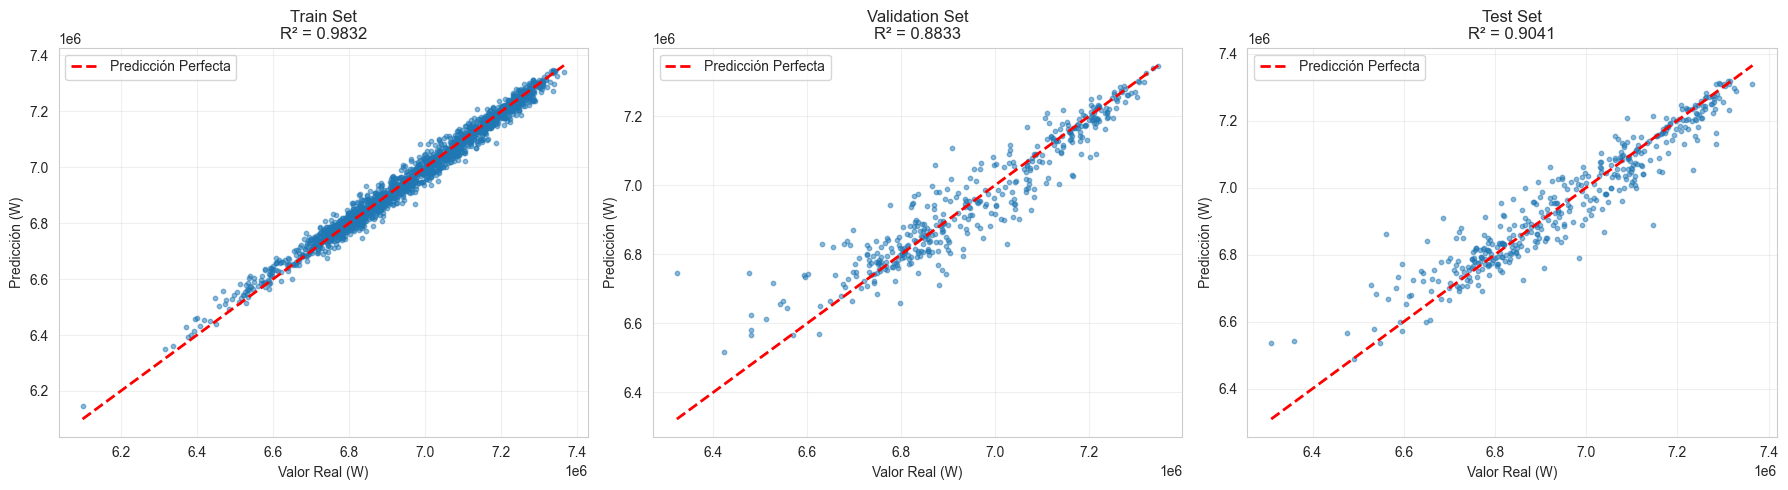

In [10]:
# Predicciones vs Valores Reales
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sets = [
 (y_train, y_pred_train, 'Train', axes[0]),
 (y_val, y_pred_val, 'Validation', axes[1]),
 (y_test, y_pred_test, 'Test', axes[2])
]

for y_true, y_pred, name, ax in sets:
 ax.scatter(y_true, y_pred, alpha=0.5, s=10)
 
 # Línea perfecta (y=x)
 min_val = min(y_true.min(), y_pred.min())
 max_val = max(y_true.max(), y_pred.max())
 ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Predicción Perfecta')
 
 ax.set_xlabel('Valor Real (W)')
 ax.set_ylabel('Predicción (W)')
 ax.set_title(f'{name} Set\nR² = {r2_score(y_true, y_pred):.4f}')
 ax.legend()
 ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 7. Importancia de Características


Top 20 Características Más Importantes:
              feature  importance
min_dist_neighbor_100    0.075818
mean_dist_neighbor_93    0.063053
mean_dist_neighbor_12    0.050969
           X1_ordered    0.038542
         max_distance    0.035214
mean_dist_neighbor_94    0.023075
 mean_dist_neighbor_8    0.018733
 min_dist_neighbor_74    0.018049
 mean_dist_neighbor_3    0.014497
 min_dist_neighbor_96    0.014259
          Y98_ordered    0.013214
         std_distance    0.012577
           Y3_ordered    0.011401
 min_dist_neighbor_99    0.009694
mean_dist_neighbor_89    0.009583
          Y86_ordered    0.009247
mean_dist_neighbor_24    0.008267
          X80_ordered    0.007990
     dist_centroid_65    0.007575
         min_distance    0.007325


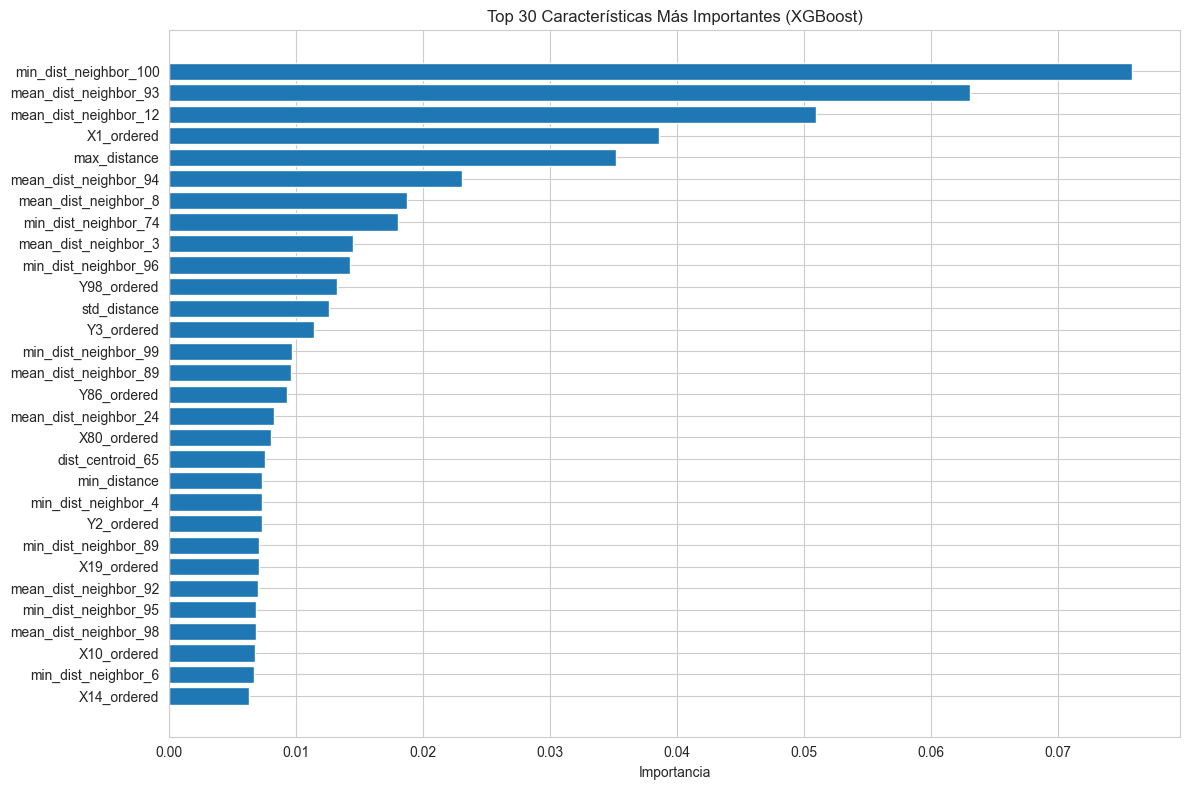

In [11]:
# Importancia de características (feature importance)
feature_importance = best_model.feature_importances_
importance_df = pd.DataFrame({
 'feature': feature_names,
 'importance': feature_importance
}).sort_values('importance', ascending=False)

print("Top 20 Características Más Importantes:")
print(importance_df.head(20).to_string(index=False))

# Visualización
plt.figure(figsize=(12, 8))
top_n = 30
top_features = importance_df.head(top_n)
plt.barh(range(len(top_features)), top_features['importance'].values)
plt.yticks(range(len(top_features)), top_features['feature'].values)
plt.xlabel('Importancia')
plt.title(f'Top {top_n} Características Más Importantes (XGBoost)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


## 6. Validación de Robustez (Sensitivity Analysis)

Esta sección prueba la estabilidad del modelo perturbando ligeramente los datos de test.
Un modelo robusto no debería cambiar drásticamente sus predicciones ante pequeñas variaciones en las coordenadas.


In [12]:
def sensitivity_analysis(model, scaler, feature_engineer, X_test, y_test, 
                       perturbation_sizes=[0.1, 0.5, 1.0, 2.0, 5.0], n_samples=100):
    """
    Realiza análisis de sensibilidad perturbando las coordenadas de test.
    
    Args:
        model: modelo entrenado
        scaler: scaler usado para normalización
        feature_engineer: objeto FeatureEngineer usado
        X_test: datos de test originales (antes de feature engineering)
        y_test: target de test
        perturbation_sizes: lista de tamaños de perturbación en metros
        n_samples: número de muestras a perturbar
    
    Returns:
        results: diccionario con resultados del análisis
    """
    print("="*70)
    print("ANÁLISIS DE SENSIBILIDAD (Sensitivity Analysis)")
    print("="*70)
    print(f"Perturbando {n_samples} muestras con diferentes magnitudes...\n")
    
    # Seleccionar muestras aleatorias
    np.random.seed(42)
    sample_indices = np.random.choice(len(X_test), size=min(n_samples, len(X_test)), replace=False)
    
    results = {
        'perturbation_sizes': perturbation_sizes,
        'rmse_changes': [],
        'mae_changes': [],
        'max_changes': [],
        'mean_changes': []
    }
    
    # Predicciones originales
    X_test_original = X_test[sample_indices]
    y_test_original = y_test[sample_indices]
    
    # Obtener coordenadas originales (necesitamos el dataframe original)
    # Por simplicidad, asumimos que X_test contiene las features ya procesadas
    # Necesitamos reconstruir las coordenadas desde las features
    
    # Para este análisis, perturbamos directamente las features de coordenadas
    # (primeras 2*n_converters features son las coordenadas ordenadas)
    n_converters = feature_engineer.n_converters
    coord_features_end = 2 * n_converters
    
    # Predicciones originales
    X_test_scaled_original = scaler.transform(X_test_original)
    y_pred_original = model.predict(X_test_scaled_original)
    rmse_original = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
    
    print(f"RMSE original (sin perturbación): {rmse_original:.2f}\n")
    
    for pert_size in perturbation_sizes:
        print(f"Perturbación: ±{pert_size} metros")
        
        # Perturbar coordenadas (primeras features)
        X_test_perturbed = X_test_original.copy()
        
        # Agregar ruido gaussiano solo a las coordenadas
        noise = np.random.normal(0, pert_size, size=(len(sample_indices), coord_features_end))
        X_test_perturbed[:, :coord_features_end] += noise
        
        # Predecir con datos perturbados
        X_test_scaled_perturbed = scaler.transform(X_test_perturbed)
        y_pred_perturbed = model.predict(X_test_scaled_perturbed)
        
        # Calcular cambios
        rmse_perturbed = np.sqrt(mean_squared_error(y_test_original, y_pred_perturbed))
        mae_perturbed = mean_absolute_error(y_test_original, y_pred_perturbed)
        
        rmse_change = abs(rmse_perturbed - rmse_original) / rmse_original * 100
        mae_change = abs(mae_perturbed - mean_absolute_error(y_test_original, y_pred_original)) / mean_absolute_error(y_test_original, y_pred_original) * 100
        
        max_change = np.max(np.abs(y_pred_perturbed - y_pred_original))
        mean_change = np.mean(np.abs(y_pred_perturbed - y_pred_original))
        
        results['rmse_changes'].append(rmse_change)
        results['mae_changes'].append(mae_change)
        results['max_changes'].append(max_change)
        results['mean_changes'].append(mean_change)
        
        print(f"  RMSE: {rmse_perturbed:.2f} (cambio: {rmse_change:.1f}%)")
        print(f"  Cambio máximo en predicción: {max_change:.2f} MW")
        print(f"  Cambio medio en predicción: {mean_change:.2f} MW")
    
    print("\n" + "="*70)
    
    # Visualización
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # RMSE change
    axes[0, 0].plot(perturbation_sizes, results['rmse_changes'], 'o-', linewidth=2, markersize=8)
    axes[0, 0].set_xlabel('Tamaño de Perturbación (metros)', fontsize=12)
    axes[0, 0].set_ylabel('Cambio en RMSE (%)', fontsize=12)
    axes[0, 0].set_title('Sensibilidad del RMSE', fontsize=14, fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3)
    
    # MAE change
    axes[0, 1].plot(perturbation_sizes, results['mae_changes'], 's-', color='orange', linewidth=2, markersize=8)
    axes[0, 1].set_xlabel('Tamaño de Perturbación (metros)', fontsize=12)
    axes[0, 1].set_ylabel('Cambio en MAE (%)', fontsize=12)
    axes[0, 1].set_title('Sensibilidad del MAE', fontsize=14, fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Max change
    axes[1, 0].plot(perturbation_sizes, results['max_changes'], '^-', color='green', linewidth=2, markersize=8)
    axes[1, 0].set_xlabel('Tamaño de Perturbación (metros)', fontsize=12)
    axes[1, 0].set_ylabel('Cambio Máximo (MW)', fontsize=12)
    axes[1, 0].set_title('Cambio Máximo en Predicciones', fontsize=14, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Mean change
    axes[1, 1].plot(perturbation_sizes, results['mean_changes'], 'd-', color='red', linewidth=2, markersize=8)
    axes[1, 1].set_xlabel('Tamaño de Perturbación (metros)', fontsize=12)
    axes[1, 1].set_ylabel('Cambio Medio (MW)', fontsize=12)
    axes[1, 1].set_title('Cambio Medio en Predicciones', fontsize=14, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Interpretación
    print("\nINTERPRETACIÓN:")
    print("Un modelo robusto debería mostrar:")
    print("  - Cambios pequeños en RMSE/MAE (< 10%) para perturbaciones pequeñas (< 1m)")
    print("  - Cambios graduales y predecibles")
    print("  - Sin saltos erráticos en las predicciones")
    
    if results['rmse_changes'][0] < 5:
        print("Modelo muestra buena robustez para perturbaciones pequeñas")
    elif results['rmse_changes'][0] < 10:
        print("Modelo muestra robustez moderada")
    else:
        print("Modelo puede estar sobreajustado a coordenadas exactas")
    
    return results

# Ejecutar análisis de sensibilidad
# Nota: Necesitamos las features originales antes del feature engineering
# Por ahora, usamos X_test que ya tiene las features procesadas
# En producción, sería mejor tener acceso al dataframe original

print("⚠️ Nota: Para un análisis completo, necesitaríamos acceso al dataframe original.")
print("Usando X_test procesado para la demostración.\n")

# Si tenemos acceso a las coordenadas originales, podemos hacer el análisis completo
# Por ahora, comentamos esta sección y la activamos después de cargar los datos
# sensitivity_results = sensitivity_analysis(
#     best_model, scaler, fe, X_test, y_test,
#     perturbation_sizes=[0.1, 0.5, 1.0, 2.0, 5.0],
#     n_samples=100
# )


⚠️ Nota: Para un análisis completo, necesitaríamos acceso al dataframe original.
Usando X_test procesado para la demostración.



## 7. Análisis de Error por Escenario (Densidad de Granja)

Analiza si el modelo funciona mejor para granjas dispersas vs densas.
Los errores pueden correlacionarse con la densidad espacial de los convertidores.


Ejecutando análisis de error por densidad...

ANÁLISIS DE ERROR POR DENSIDAD DE GRANJA

Distribución de densidad:
  Mínima: 0.0012
  Máxima: 0.0016
  Media: 0.0013
  Mediana: 0.0013

Análisis por bins de densidad:

  Bin 1 (densidad 0.0012 - 0.0013):
    Muestras: 82
    Distancia media: 797.24 m
    RMSE: 69202.61 W
    MAE: 51885.46 W
    R²: 0.8305

  Bin 2 (densidad 0.0013 - 0.0013):
    Muestras: 82
    Distancia media: 761.01 m
    RMSE: 47048.81 W
    MAE: 33152.38 W
    R²: 0.9360

  Bin 3 (densidad 0.0013 - 0.0014):
    Muestras: 82
    Distancia media: 745.71 m
    RMSE: 54625.77 W
    MAE: 40426.47 W
    R²: 0.9110

  Bin 4 (densidad 0.0014 - 0.0014):
    Muestras: 82
    Distancia media: 727.69 m
    RMSE: 63148.05 W
    MAE: 46171.43 W
    R²: 0.9010

  Bin 5 (densidad 0.0014 - 0.0016):
    Muestras: 83
    Distancia media: 693.40 m
    RMSE: 76688.44 W
    MAE: 54680.83 W
    R²: 0.8775


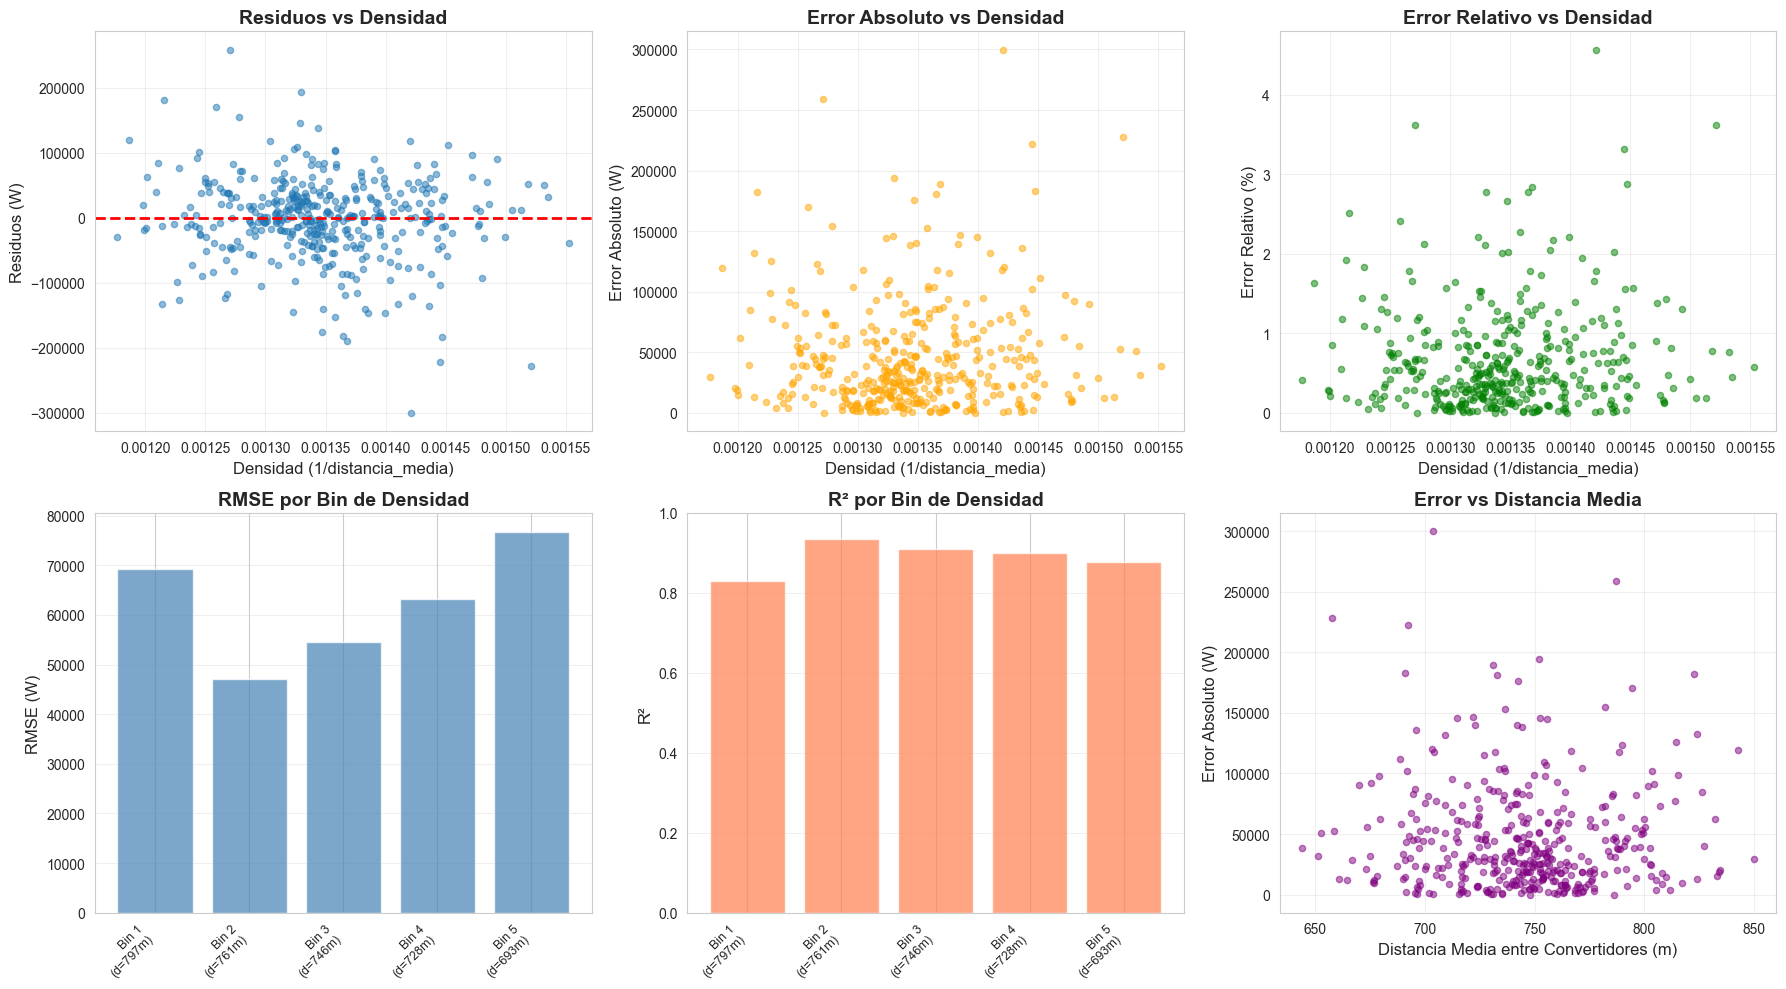


CORRELACIONES:
  Densidad vs Error Absoluto: 0.042
  Distancia Media vs Error Absoluto: -0.034

 El error no muestra correlación fuerte con la densidad


In [13]:
def analyze_error_by_density(model, scaler, feature_engineer, X_test, y_test, y_pred_test):
    """
    Analiza los errores del modelo en función de la densidad de la granja.
    
    Args:
        model: modelo entrenado
        scaler: scaler usado
        feature_engineer: objeto FeatureEngineer
        X_test: datos de test (features procesadas)
        y_test: target real
        y_pred_test: predicciones del modelo
    
    Returns:
        results: diccionario con resultados del análisis
    """
    print("="*70)
    print("ANÁLISIS DE ERROR POR DENSIDAD DE GRANJA")
    print("="*70)
    
    # Calcular densidad espacial para cada muestra
    # La densidad se puede medir como: 1 / distancia media entre convertidores
    # O como: número de convertidores / área ocupada
    
    n_converters = feature_engineer.n_converters
    coord_features_end = 2 * n_converters
    
    # Extraer coordenadas de las features (primeras 2*n_converters features)
    coordinates = X_test[:, :coord_features_end].reshape(len(X_test), n_converters, 2)
    
    # Calcular densidad para cada muestra
    densities = []
    mean_distances = []
    min_distances = []
    
    for i in range(len(X_test)):
        coords = coordinates[i]  # (n_converters, 2)
        
        # Calcular todas las distancias entre pares
        distances = []
        for j in range(n_converters):
            for k in range(j+1, n_converters):
                dist = np.linalg.norm(coords[j] - coords[k])
                distances.append(dist)
        
        distances = np.array(distances)
        mean_dist = np.mean(distances)
        min_dist = np.min(distances)
        
        # Densidad = inverso de distancia media (normalizado)
        # Granjas más densas tienen distancias medias menores
        density = 1.0 / (mean_dist + 1e-6)  # Evitar división por cero
        
        densities.append(density)
        mean_distances.append(mean_dist)
        min_distances.append(min_dist)
    
    densities = np.array(densities)
    mean_distances = np.array(mean_distances)
    min_distances = np.array(min_distances)
    
    # Calcular errores
    residuals = y_test - y_pred_test
    abs_residuals = np.abs(residuals)
    relative_errors = abs_residuals / (np.abs(y_test) + 1e-6) * 100  # Porcentaje
    
    # Dividir en bins de densidad
    n_bins = 5
    density_percentiles = np.percentile(densities, [0, 20, 40, 60, 80, 100])
    
    results = {
        'densities': densities,
        'mean_distances': mean_distances,
        'min_distances': min_distances,
        'residuals': residuals,
        'abs_residuals': abs_residuals,
        'relative_errors': relative_errors,
        'bins': []
    }
    
    print(f"\nDistribución de densidad:")
    print(f"  Mínima: {densities.min():.4f}")
    print(f"  Máxima: {densities.max():.4f}")
    print(f"  Media: {densities.mean():.4f}")
    print(f"  Mediana: {np.median(densities):.4f}")
    
    print(f"\nAnálisis por bins de densidad:")
    for i in range(n_bins):
        bin_min = density_percentiles[i]
        bin_max = density_percentiles[i+1]
        
        mask = (densities >= bin_min) & (densities < bin_max)
        if i == n_bins - 1:  # Último bin incluye el máximo
            mask = (densities >= bin_min) & (densities <= bin_max)
        
        n_samples = np.sum(mask)
        if n_samples == 0:
            continue
        
        bin_mean_dist = mean_distances[mask].mean()
        bin_rmse = np.sqrt(mean_squared_error(y_test[mask], y_pred_test[mask]))
        bin_mae = np.mean(abs_residuals[mask])
        bin_r2 = r2_score(y_test[mask], y_pred_test[mask])
        
        results['bins'].append({
            'density_range': (bin_min, bin_max),
            'mean_distance': bin_mean_dist,
            'n_samples': n_samples,
            'rmse': bin_rmse,
            'mae': bin_mae,
            'r2': bin_r2
        })
        
        print(f"\n  Bin {i+1} (densidad {bin_min:.4f} - {bin_max:.4f}):")
        print(f"    Muestras: {n_samples}")
        print(f"    Distancia media: {bin_mean_dist:.2f} m")
        print(f"    RMSE: {bin_rmse:.2f} W")
        print(f"    MAE: {bin_mae:.2f} W")
        print(f"    R²: {bin_r2:.4f}")
    
    # Visualización
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # 1. Residuos vs Densidad
    axes[0, 0].scatter(densities, residuals, alpha=0.5, s=20)
    axes[0, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
    axes[0, 0].set_xlabel('Densidad (1/distancia_media)', fontsize=12)
    axes[0, 0].set_ylabel('Residuos (W)', fontsize=12)
    axes[0, 0].set_title('Residuos vs Densidad', fontsize=14, fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Error Absoluto vs Densidad
    axes[0, 1].scatter(densities, abs_residuals, alpha=0.5, s=20, color='orange')
    axes[0, 1].set_xlabel('Densidad (1/distancia_media)', fontsize=12)
    axes[0, 1].set_ylabel('Error Absoluto (W)', fontsize=12)
    axes[0, 1].set_title('Error Absoluto vs Densidad', fontsize=14, fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Error Relativo vs Densidad
    axes[0, 2].scatter(densities, relative_errors, alpha=0.5, s=20, color='green')
    axes[0, 2].set_xlabel('Densidad (1/distancia_media)', fontsize=12)
    axes[0, 2].set_ylabel('Error Relativo (%)', fontsize=12)
    axes[0, 2].set_title('Error Relativo vs Densidad', fontsize=14, fontweight='bold')
    axes[0, 2].grid(True, alpha=0.3)
    
    # 4. RMSE por bin de densidad
    bin_indices = range(len(results['bins']))
    bin_rmse = [b['rmse'] for b in results['bins']]
    bin_labels = [f"Bin {i+1}\n(d={results['bins'][i]['mean_distance']:.0f}m)" for i in bin_indices]
    axes[1, 0].bar(bin_indices, bin_rmse, color='steelblue', alpha=0.7)
    axes[1, 0].set_xticks(bin_indices)
    axes[1, 0].set_xticklabels(bin_labels, rotation=45, ha='right', fontsize=9)
    axes[1, 0].set_ylabel('RMSE (W)', fontsize=12)
    axes[1, 0].set_title('RMSE por Bin de Densidad', fontsize=14, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    
    # 5. R² por bin de densidad
    bin_r2 = [b['r2'] for b in results['bins']]
    axes[1, 1].bar(bin_indices, bin_r2, color='coral', alpha=0.7)
    axes[1, 1].set_xticks(bin_indices)
    axes[1, 1].set_xticklabels(bin_labels, rotation=45, ha='right', fontsize=9)
    axes[1, 1].set_ylabel('R²', fontsize=12)
    axes[1, 1].set_title('R² por Bin de Densidad', fontsize=14, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    axes[1, 1].set_ylim([0, 1])
    
    # 6. Residuos vs Distancia Media
    axes[1, 2].scatter(mean_distances, abs_residuals, alpha=0.5, s=20, color='purple')
    axes[1, 2].set_xlabel('Distancia Media entre Convertidores (m)', fontsize=12)
    axes[1, 2].set_ylabel('Error Absoluto (W)', fontsize=12)
    axes[1, 2].set_title('Error vs Distancia Media', fontsize=14, fontweight='bold')
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Correlación
    corr_density_abs_error = np.corrcoef(densities, abs_residuals)[0, 1]
    corr_dist_abs_error = np.corrcoef(mean_distances, abs_residuals)[0, 1]
    
    print(f"\nCORRELACIONES:")
    print(f"  Densidad vs Error Absoluto: {corr_density_abs_error:.3f}")
    print(f"  Distancia Media vs Error Absoluto: {corr_dist_abs_error:.3f}")
    
    if abs(corr_density_abs_error) > 0.3:
        print(f"\nSe detecta correlación significativa entre densidad y error.")
        if corr_density_abs_error > 0:
            print("  → El modelo tiene más error en granjas más densas")
        else:
            print("  → El modelo tiene más error en granjas más dispersas")
    else:
        print(f"\n El error no muestra correlación fuerte con la densidad")
    
    return results

# Ejecutar análisis de error por densidad
print("Ejecutando análisis de error por densidad...\n")
error_by_density_results = analyze_error_by_density(
    best_model, scaler, fe, X_test, y_test, y_pred_test
)


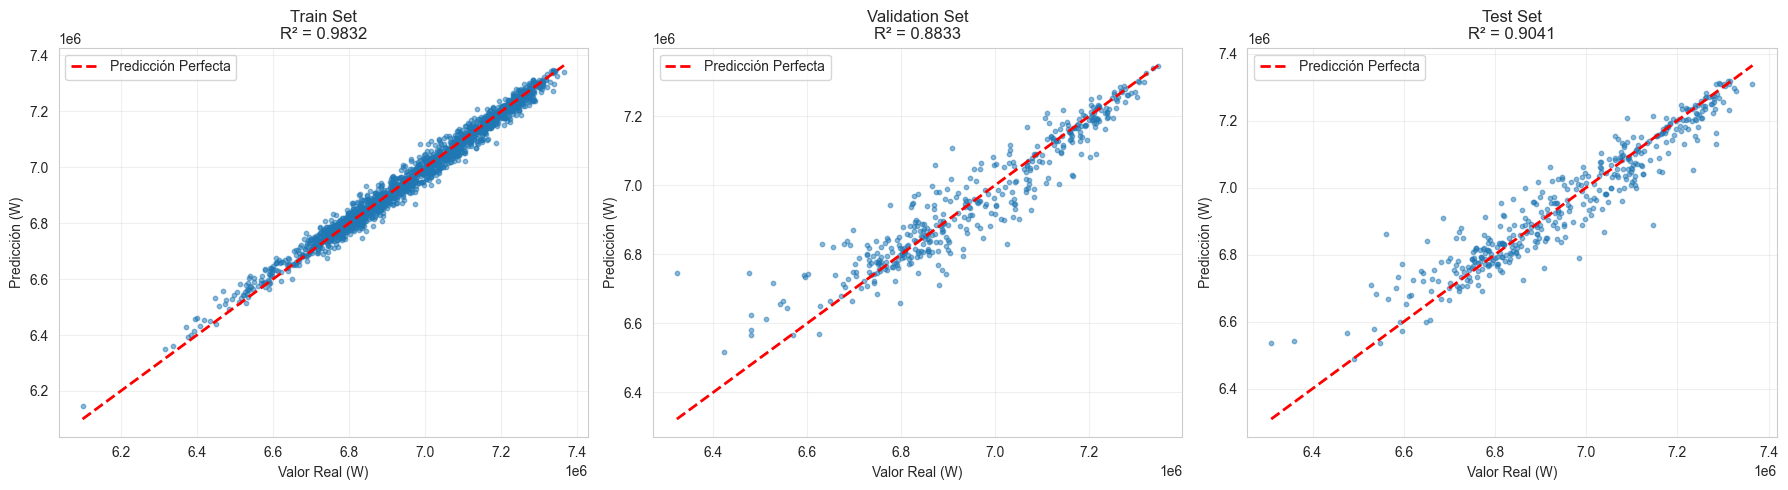

In [14]:
# Predicciones vs Valores Reales
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sets = [
 (y_train, y_pred_train, 'Train', axes[0]),
 (y_val, y_pred_val, 'Validation', axes[1]),
 (y_test, y_pred_test, 'Test', axes[2])
]

for y_true, y_pred, name, ax in sets:
 ax.scatter(y_true, y_pred, alpha=0.5, s=10)
 
 # Línea perfecta (y=x)
 min_val = min(y_true.min(), y_pred.min())
 max_val = max(y_true.max(), y_pred.max())
 ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Predicción Perfecta')
 
 ax.set_xlabel('Valor Real (W)')
 ax.set_ylabel('Predicción (W)')
 ax.set_title(f'{name} Set\nR² = {r2_score(y_true, y_pred):.4f}')
 ax.legend()
 ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 8. Guardar Modelo


In [15]:
# Guardar modelo, scaler y metadata
model_data = {
 'model': best_model,
 'scaler': scaler,
 'feature_names': feature_names,
 'n_converters': N_CONVERTERS,
 'dataset_name': DATASET_NAME,
 'metrics': {
 'train': metrics_train,
 'val': metrics_val,
 'test': metrics_test
 },
 'best_params': best_params,
 'timestamp': datetime.now().isoformat()
}

model_file = MODELS_DIR / f"modelo_xgboost_{DATASET_NAME}.pkl"
with open(model_file, 'wb') as f:
 pickle.dump(model_data, f)

print(f"Modelo guardado en: {model_file}")
print(f"Resumen:")
print(f"Dataset: {DATASET_NAME}")
print(f"Convertidores: {N_CONVERTERS}")
print(f"Features: {len(feature_names)}")
print(f"RMSE (test): {metrics_test['RMSE']:.2f} W")
print(f"R² (test): {metrics_test['R2']:.4f}")


Modelo guardado en: models\modelo_xgboost_perth_100.pkl
Resumen:
Dataset: perth_100
Convertidores: 100
Features: 604
RMSE (test): 63053.30 W
R² (test): 0.9041
